# A. Neural Machine Translation with Transformer model

## 0. Import libraries

In [ ]:
# %%capture
# !pip install fasttext underthesea nltk 

In [5]:
import re
import json
import string
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

## 1. Vectorizing the text data and format our datasets

Load data

In [1]:
# Load train
with open("data/train.en.txt", encoding="utf-8") as f:
    train_en = [line.strip() for line in f]

with open("data/train.vi.txt", encoding="utf-8") as f:
    train_vi = [line.strip() for line in f]

# Load test
with open("data/test.en.txt", encoding="utf-8") as f:
    test_en = [line.strip() for line in f]

with open("data/test.vi.txt", encoding="utf-8") as f:
    test_vi = [line.strip() for line in f]

val_ratio = 0.02
val_size = int(len(train_en) * val_ratio)

val_en = train_en[-val_size:]
val_vi = train_vi[-val_size:]

train_en = train_en[:-val_size]
train_vi = train_vi[:-val_size]

print(f"Train size: {len(train_en)}, Validation size: {len(val_en)}")

Train size: 490000, Validation size: 10000


In [8]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace('[', '')
strip_chars = strip_chars.replace(']', '')

vocab_size = 15000
sequence_length = 40
batch_size = 64

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, '[%s]' % re.escape(strip_chars), '')

en_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)
vi_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)

en_vectorization.adapt(train_en)
vi_vectorization.adapt(train_vi)

In [10]:
def format_dataset(en, vi):
    en = en_vectorization(en)
    vi = vi_vectorization(vi)
    return ({
        'encoder_inputs': en,
        'decoder_inputs': vi[:, :-1]
    }, vi[:, 1:])

def make_dataset(src, tgt):
    src = list(src)
    tgt = list(tgt)
    
    dataset = tf.data.Dataset.from_tensor_slices((src, tgt))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_en, train_vi)
val_ds = make_dataset(val_en, val_vi)

In [11]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 40)
inputs["decoder_inputs"].shape: (64, 40)
targets.shape: (64, 40)


## 2. Building the model

In [12]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads
        })
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads
        })
        return config

In [13]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

## 3. Training our model

In [12]:
epochs = 50

transformer.summary()
transformer.compile(
    optimizer="rmsprop", 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    3850240     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 256)    3155456     positional_embedding[0][0]       
________________________________________________________________________________________

2022-04-26 18:40:09.545252: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1747/1747 [==============================] - 167s 92ms/step - loss: 2.3505 - accuracy: 0.2573 - val_loss: 2.0354 - val_accuracy: 0.3293
Epoch 2/50
1747/1747 [==============================] - 160s 91ms/step - loss: 2.0257 - accuracy: 0.3423 - val_loss: 1.8452 - val_accuracy: 0.3719
Epoch 3/50
1747/1747 [==============================] - 160s 92ms/step - loss: 1.8617 - accuracy: 0.3812 - val_loss: 1.7357 - val_accuracy: 0.3989
Epoch 4/50
1747/1747 [==============================] - 160s 92ms/step - loss: 1.7485 - accuracy: 0.4087 - val_loss: 1.6806 - val_accuracy: 0.4162
Epoch 5/50
1747/1747 [==============================] - 160s 92ms/step - loss: 1.6793 - accuracy: 0.4283 - val_loss: 1.6585 - val_accuracy: 0.4226
Epoch 6/50
1747/1747 [==============================] - 160s 92ms/step - loss: 1.6442 - accuracy: 0.4438 - val_loss: 1.6570 - val_accuracy: 0.4281
Epoch 7/50
1747/1747 [==============================] - 161s 92ms/step - loss: 1.6174 - accuracy: 0.4563 - val_loss: 1.6525 - val

In [13]:
json.dump(history.history, open('./history.json', 'w'))

Plot loss and accuracy

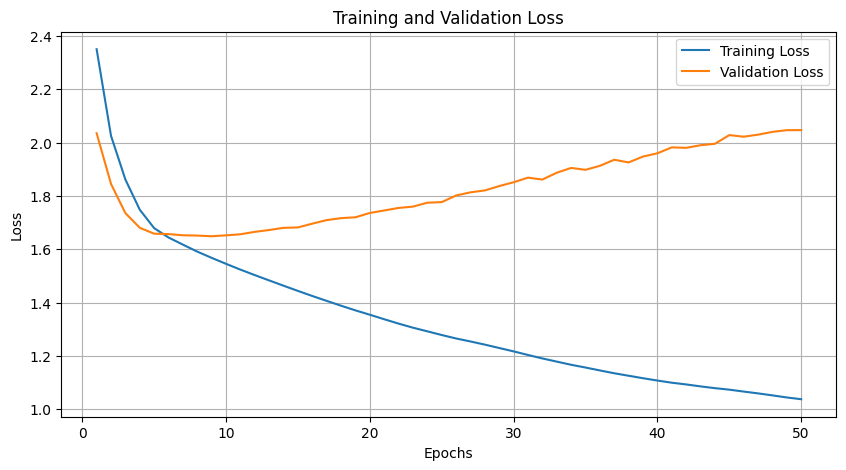

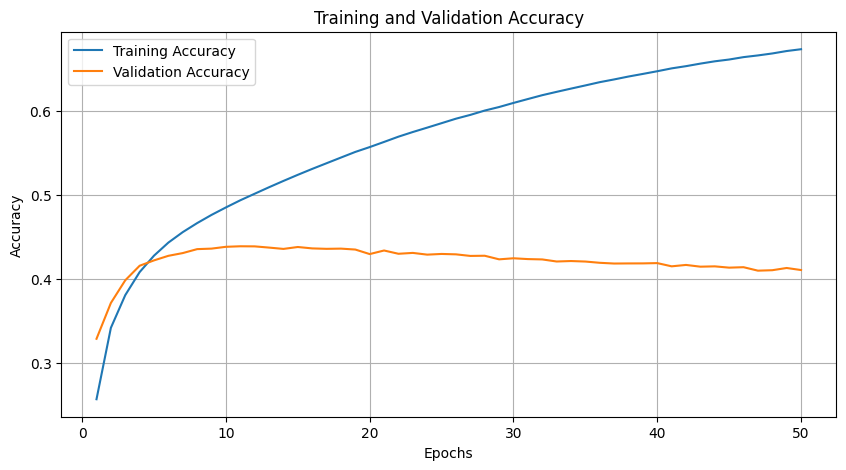

In [6]:
with open('history.json', 'r') as f:
    history = json.load(f)

epochs = range(1, len(history['loss']) + 1)

# Vẽ Loss
plt.figure(figsize=(10,5))
plt.plot(epochs, history['loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs, history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
transformer.save('./best_model.h5')

In [15]:
vi_vocab = vi_vectorization.get_vocabulary()
vi_index_lookup = dict(zip(range(len(vi_vocab)), vi_vocab))
max_decoded_sentence_length = 40

def decode_sequence(input_sentence):
    tokenized_input_sentence = en_vectorization([input_sentence])
    decoded_sentence = '[start]'
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vi_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = vi_index_lookup[sampled_token_index]
        decoded_sentence += ' ' + sampled_token
        
        if sampled_token == '[end]':
            break
    return decoded_sentence

In [ ]:
for i in range(10):
    input_sentence = random.choice(test_en)
    translated = decode_sequence(input_sentence)
    print(f'{"%02d" % (i + 1)}: {input_sentence} ---> {translated}')

01: Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao ---> [start]Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017 [end]
02: Describe knowledge, practices in public health service utilization among health insurance card's holders and influencing factors in Vientiane, Lao PDR, 2017. ---> [start]Mô tả thực trạng kiến thức, thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố liên quan tại tỉnh Viêng Chăn, Cộng hoà Dân chủ Nhân dân Lào năm 2017. [end]
03: Methodology: A cross sectional study was used among 928 adult health insurance card's holders in Phone Hong and Keo Oudom districts, Vientiane province. ---> [start]Phương pháp: Thiết kế nghiên mô tả cắt ngang được thực hiện trên 928 người trưởng 

# B. Analyzing NMT Systems

# 1. Translation test set

In [15]:
model = keras.models.load_model(
    "best_model.h5",
    custom_objects={
        "TransformerEncoder": TransformerEncoder,
        "TransformerDecoder": TransformerDecoder,
        "PositionalEmbedding": PositionalEmbedding
    }
)

In [25]:
start_token = vi_vectorization(["<start>"]).numpy()[0, 0]
end_token = vi_vectorization(["<end>"]).numpy()[0, 0]
max_len = 40

def translate_sentence(sentence):
    encoder_input = en_vectorization([sentence])

    decoder_input = np.zeros((1, max_len), dtype=np.int64)
    decoder_input[0, 0] = start_token

    for i in range(1, max_len):
        preds = model({"encoder_inputs": encoder_input, "decoder_inputs": decoder_input})
        next_token = tf.argmax(preds[0, i-1]).numpy()
        decoder_input[0, i] = next_token
        if next_token == end_token:
            break

    ids = decoder_input[0, 1:i]  # bỏ <start>
    words = vi_vectorization.get_vocabulary()
    tokens = [words[t] for t in ids if t != 0 and t != end_token]
    return " ".join(tokens)

BLEU

In [7]:
import sacrebleu

with open("outputs/test_outputs.txt", "r", encoding="utf-8") as f:
    machine_trans = [line.strip() for line in f]

with open("data/test.vi.txt", "r", encoding="utf-8") as f:
    reference_trans = [line.strip() for line in f]

# Tính BLEU score
bleu = sacrebleu.corpus_bleu(machine_trans, [reference_trans])
print(f"BLEU score: {bleu.score:.2f}")

BLEU score: 22.59
